In [1]:
import torch
import torch.nn.functional as F
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import pandas as pd
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix
from loss import MixedEdgeWeightedLoss

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


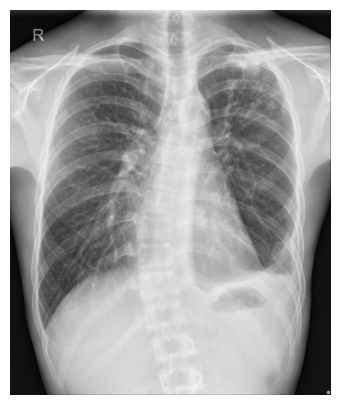

In [3]:
image = Image.open('/root/lung-segment/images/0.png')
image = np.array(image.convert("RGB"))
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.show()

In [4]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "/root/sam2/CXR/fold_0_finetuned_sam2.1.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)
predictor.set_image(image)

In [24]:
def torch_sobel_edge(mask: torch.Tensor, sigma=1.0) -> torch.Tensor:
    """GPU加速的Sobel边缘检测，输出[0,1]边缘概率"""
    # 高斯平滑
    kernel_size = int(4*sigma + 1)
    mask_float = mask.float().unsqueeze(1)  # [B,1,H,W]
    blurred = T.functional.gaussian_blur(mask_float, kernel_size=[kernel_size]*2, sigma=[sigma]*2)
    
    # Sobel算子
    sobel_x = F.conv2d(blurred, torch.tensor([[[[-1,0,1], [-2,0,2], [-1,0,1]]]], 
                        device=mask.device, dtype=blurred.dtype), padding=1)
    sobel_y = F.conv2d(blurred, torch.tensor([[[[-1,-2,-1], [0,0,0], [1,2,1]]]], 
                        device=mask.device, dtype=blurred.dtype), padding=1)
    edge_mag = torch.sqrt(sobel_x**2 + sobel_y**2)
    edge_mag = F.max_pool2d(edge_mag, 50, stride=1, padding=25)[:,:,:mask_float.shape[2], :mask_float.shape[3]]
    return (edge_mag > 0.0001 * edge_mag.max()).float()  # 二值化
    
def predict_mask(predictor:SAM2ImagePredictor, points, labels, boxes, mask):
    # prompt encoding
    if points is not None:
        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=(points, labels), boxes=boxes,masks=mask)
    else:
        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=None, boxes=boxes,masks=mask)

    #print(predictor._features["image_embed"].shape)
    # mask decoder
    high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
    low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(image_embeddings=predictor._features["image_embed"],image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),sparse_prompt_embeddings=sparse_embeddings,dense_prompt_embeddings=dense_embeddings,multimask_output=False,repeat_image=False,high_res_features=high_res_features,)
    prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])# Upscale the masks to the original image resolution
    print(low_res_masks.min(), low_res_masks.max(), torch.median(low_res_masks), low_res_masks.shape)
    prd_mask = torch.sigmoid(prd_masks[:, 0]) # Turn logit map to probability map
    return low_res_masks, prd_mask, prd_scores

In [12]:
low_res_masks, prd_mask, prd_scores = predict_mask(predictor, None, None, None, None)
low_res_masks.shape, prd_mask, prd_scores

tensor(-22.2500, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MinBackward1>) tensor(8.2500, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>) tensor(-7.1250, device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<MedianBackward0>) torch.Size([1, 1, 256, 256])


(torch.Size([1, 1, 256, 256]),
 tensor([[[2.4300e-05, 2.4300e-05, 2.4300e-05,  ..., 1.3846e-05,
           1.3846e-05, 1.3846e-05],
          [2.4300e-05, 2.4300e-05, 2.4300e-05,  ..., 1.3846e-05,
           1.3846e-05, 1.3846e-05],
          [2.4300e-05, 2.4300e-05, 2.4300e-05,  ..., 1.3846e-05,
           1.3846e-05, 1.3846e-05],
          ...,
          [5.7719e-06, 5.7719e-06, 5.7719e-06,  ..., 1.6865e-04,
           1.6865e-04, 1.6865e-04],
          [5.7719e-06, 5.7719e-06, 5.7719e-06,  ..., 1.6865e-04,
           1.6865e-04, 1.6865e-04],
          [5.7719e-06, 5.7719e-06, 5.7719e-06,  ..., 1.6865e-04,
           1.6865e-04, 1.6865e-04]]], device='cuda:0',
        grad_fn=<SigmoidBackward0>),
 tensor([[0.9062]], device='cuda:0', dtype=torch.bfloat16,
        grad_fn=<WhereBackward0>))

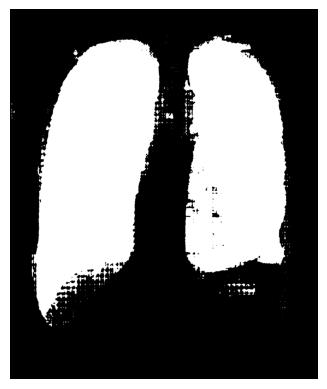

In [29]:
np_img = (prd_mask[0].float() > 0.01).cpu().detach().numpy()
plt.imshow(np_img, cmap='gray')
plt.axis("off")
plt.show()

uint8


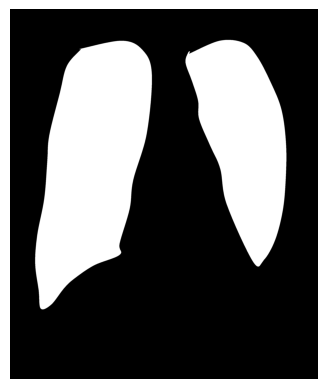

In [30]:
gt = np.array(Image.open('/root/lung-segment/masks/0-mask.png'))
print(gt.dtype)
plt.imshow(gt, cmap='gray')
plt.axis("off")
plt.show()
# print(np_img.astype(np.uint8).any() not in [0, 1])
# gt_edge = torch_sobel_edge(torch.tensor(gt).unsqueeze(0))[0][0].numpy()
# plt.imshow(gt_edge, cmap='gray')
# plt.axis("off")
# plt.show()

In [26]:
gt_masks = torch.tensor(gt, device=prd_mask.device, dtype=torch.float32).unsqueeze(0) // 255
edge_map = torch_sobel_edge(gt_masks)
print(gt_masks.shape, edge_map.shape)
seg_loss = (-gt_masks * torch.log(prd_mask + 1e-6) - (1 - gt_masks) * torch.log((1 - prd_mask) + 1e-6)).mean() # cross entropy loss
# + 4.0 * edge_map  # 边缘区域权重设为5
edge_weight = 1.0 + 2.0 * edge_map # 边缘区域权重设为5
weighted_seg_loss = (- (edge_weight * gt_masks) * torch.log(prd_mask + 1e-6) 
                     - (edge_weight * (1 - gt_masks)) * torch.log((1 - prd_mask) + 1e-6)).mean()
edge_weighted_bce = MixedEdgeWeightedLoss()

weighted_seg_loss, seg_loss, edge_weighted_bce(gt_masks, prd_mask, prd_scores)

torch.Size([1, 2945, 2450]) torch.Size([1, 1, 2945, 2450])
tensor(0.1648, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.1512, device='cuda:0') tensor(0.0818, device='cuda:0') tensor(0.0586, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)


(tensor(0.3214, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.1440, device='cuda:0', grad_fn=<MeanBackward0>),
 (tensor(0.1794, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.8488, device='cuda:0'),
  tensor(0.9182, device='cuda:0')))

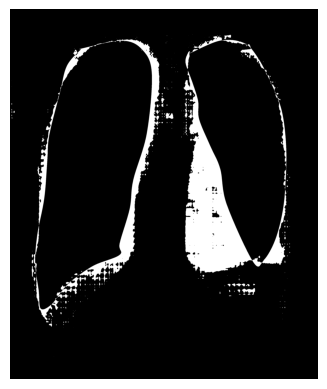

In [27]:
difference_map = (np_img * 255 !=gt)
plt.imshow(difference_map, cmap='gray')
plt.axis("off")
plt.show()

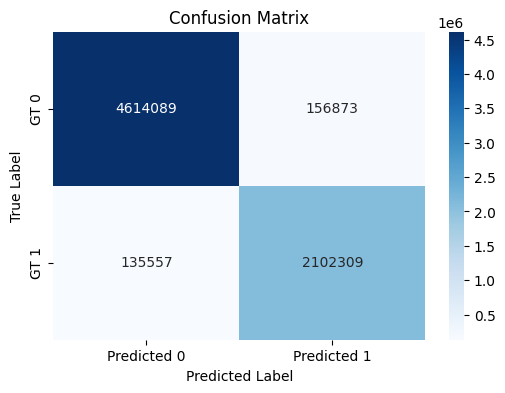

292430


In [21]:
import seaborn as sns

cm = confusion_matrix(gt.flatten(), np_img.astype(np.uint8).flatten() * 255)
# 可视化混淆矩阵
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["GT 0", "GT 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
print(cm[0][1] + cm[1][0])

In [12]:
np.unique(gt)

array([  0, 255], dtype=uint8)

In [13]:
np.unique(np_img.astype(np.uint8))

array([0, 1], dtype=uint8)

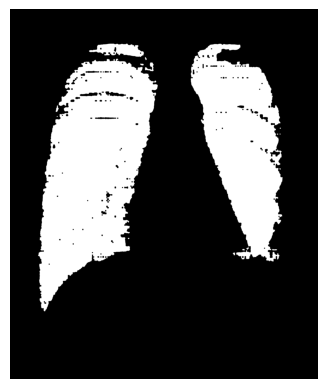

In [10]:
open_prd_mask = morphological_open(prd_mask.unsqueeze(1), 14)
np_img = (open_prd_mask[0][0].float() > 0.5).cpu().detach().numpy()
plt.imshow(np_img, cmap='gray')
plt.axis("off")
plt.show()

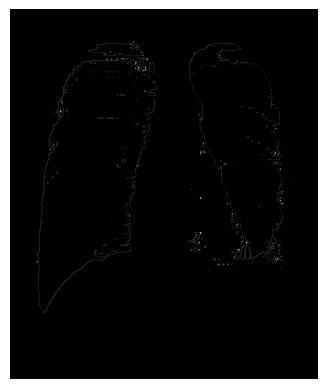

In [54]:
difference_map = ((open_prd_mask > 0.5) != (prd_mask > 0.5)).float().cpu().detach().numpy()
plt.imshow(difference_map[0][0], cmap='gray')
plt.axis("off")
plt.show()

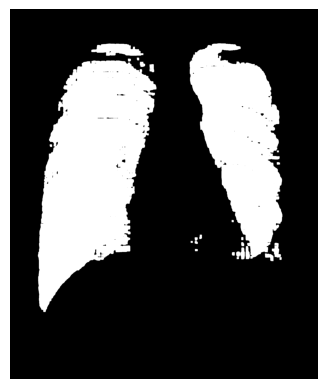

In [34]:
open_close_prd_mask = morphological_close(open_prd_mask, 1)
np_img = (open_close_prd_mask[0][0].float() > 0.5).cpu().detach().numpy()
plt.imshow(np_img, cmap='gray')
plt.axis("off")
plt.show()

torch.Size([1, 1, 2945, 2450]) torch.Size([1, 1, 2945, 2450]) torch.Size([1, 2945, 2450])


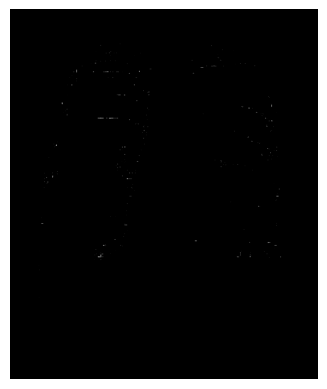

In [32]:
print(open_prd_mask.shape, open_close_prd_mask.shape, prd_mask.shape)
difference_map = ((open_prd_mask > 0.5) != (open_close_prd_mask > 0.5)).float().cpu().detach().numpy()
plt.imshow(difference_map[0][0], cmap='gray')
plt.axis("off")
plt.show()